Topic modelling for twitter project


In [3]:
import nltk
import re
import numpy as np
import pandas as pd
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# NLTK Stop words
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Darren\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# Import Dataset twitter
df = pd.read_csv("spcatwitter.csv")
print(df.columns.unique())
df.tail()
#number of group 10

Index(['date', 'text'], dtype='object')


,date,text
1274,16/3/2020 13:25,b'Waited 7 months to go home to Singapore and ...
1275,16/3/2020 12:45,"b""I will support Cravity the same way as I sup..."
1276,16/3/2020 11:01,b'The United Nations Convention on Internation...
1277,16/3/2020 10:01,"b'RT @stompsingapore: ""His body was strung up ..."
1278,16/3/2020 8:43,"b'""His body was strung up on a pipe for all re..."


In [7]:
# Convert to list
data = df.text.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

#remove for twitter
data = [re.sub("b", ' ', sent) for sent in data]
data = [re.sub("via", ' ', sent) for sent in data]
data = [re.sub("https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+", ' ', sent) for sent in data]
data = [re.sub("/.*", ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

<input>:5: DeprecationWarning: invalid escape sequence \S
<input>:8: DeprecationWarning: invalid escape sequence \s
<input>:13: DeprecationWarning: invalid escape sequence \w
<input>:5: DeprecationWarning: invalid escape sequence \S
<input>:8: DeprecationWarning: invalid escape sequence \s
<input>:13: DeprecationWarning: invalid escape sequence \w
<input>:5: DeprecationWarning: invalid escape sequence \S
<input>:8: DeprecationWarning: invalid escape sequence \s
<input>:13: DeprecationWarning: invalid escape sequence \w
<ipython-input-7-b0cf51d4527e>:5: DeprecationWarning: invalid escape sequence \S
  data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
<ipython-input-7-b0cf51d4527e>:8: DeprecationWarning: invalid escape sequence \s
  data = [re.sub('\s+', ' ', sent) for sent in data]
<ipython-input-7-b0cf51d4527e>:13: DeprecationWarning: invalid escape sequence \w
  data = [re.sub("https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+", ' ', sent) for sent in data]


In [8]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

In [9]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [10]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [11]:
import en_core_web_sm


# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = en_core_web_sm.load(disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [12]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)]]


In [13]:
from gensim.models import CoherenceModel
def calculate_coherencescore_for_topics(corpus_vect,dictionary,processed_docs,n=10):
    score = []
    for i in range(1,11):
        ldamodel = gensim.models.ldamodel.LdaModel(corpus_vect, num_topics = i, id2word=dictionary, passes=25, random_state= 0)
        # Compute Coherence Score
        coherence_model_lda = CoherenceModel(model=ldamodel, texts=processed_docs, dictionary=dictionary, coherence='c_v')
        coherence_lda = coherence_model_lda.get_coherence()
        score.append(coherence_lda)
    return score
    
score = calculate_coherencescore_for_topics(corpus,id2word,data_lemmatized)

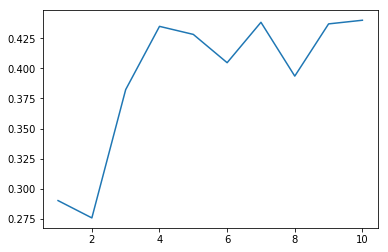

In [14]:
import matplotlib.pyplot as plt
import numpy as np


plt.plot([1,2,3,4,5,6,7,8,9,10],score)
plt.show()

In [19]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [20]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

C:\Users\Darren\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.270479 -0.034626       1        1  37.637852
0     -0.051598  0.239910       2        1  22.263298
1     -0.097742 -0.133493       3        1  20.672333
3     -0.121139 -0.071792       4        1  19.426514, topic_info=     Category        Freq        Term       Total  loglift  logprob
term                                                               
220   Default   80.000000       think   80.000000  30.0000  30.0000
34    Default   74.000000          go   74.000000  29.0000  29.0000
413   Default   40.000000       could   40.000000  28.0000  28.0000
1611  Default   40.000000        drug   40.000000  27.0000  27.0000
69    Default   62.000000        home   62.000000  26.0000  26.0000
51    Default   34.000000    adoption   34.000000  25.0000  25.0000
3     Default   58.000000        need   58.000000  24.0000  24.0000
568   Default   36.000000        case   36.000000  23.0000  23.0000
27    Default   32.000000        find   32.000000  22.0000  22.0000
19    Default   51.000000        help   51.000000  21.0000  21.0000
66    Default   50.000000        spca   50.000000  20.0000  20.0000
46    Default   50.000000        come   50.000000  19.0000  19.0000
0     Default   84.000000      animal   84.000000  18.0000  18.0000
18    Default   50.000000         get   50.000000  17.0000  17.0000
93    Default   47.000000        time   47.000000  16.0000  16.0000
143   Default   24.000000       would   24.000000  15.0000  15.0000
10    Default   43.000000         cat   43.000000  14.0000  14.0000
349   Default   25.000000       close   25.000000  13.0000  13.0000
295   Default   41.000000       today   41.000000  12.0000  12.0000
381   Default   41.000000     shelter   41.000000  11.0000  11.0000
5     Default   41.000000         pet   41.000000  10.0000  10.0000
170   Default   25.000000        know   25.000000   9.0000   9.0000
422   Default   24.000000         key   24.000000   8.0000   8.0000
58    Default  104.000000         dog  104.000000   7.0000   7.0000
327   Default   22.000000        open   22.000000   6.0000   6.0000
43    Default   23.000000   treatment   23.000000   5.0000   5.0000
169   Default   23.000000        keep   23.000000   4.0000   4.0000
172   Default   23.000000        make   23.000000   3.0000   3.0000
52    Default   36.000000          be   36.000000   2.0000   2.0000
112   Default   20.000000        give   20.000000   1.0000   1.0000
...       ...         ...         ...         ...      ...      ...
112    Topic4   19.691927        give   20.345905   1.6059  -4.2191
117    Topic4   18.869673        love   19.562689   1.6025  -4.2617
139    Topic4   16.901955         amp   17.587873   1.5988  -4.3719
76     Topic4   17.691240         use   18.441706   1.5970  -4.3262
248    Topic4   14.515253        much   15.192666   1.5929  -4.5241
573    Topic4   12.293957        send   12.939552   1.5874  -4.6902
16     Topic4   11.676541         ask   12.319220   1.5850  -4.7417
941    Topic4   12.684114         een   13.393969   1.5841  -4.6589
189    Topic4   11.997587         may   12.673222   1.5837  -4.7146
304    Topic4   11.617972         due   12.276308   1.5834  -4.7467
276    Topic4   11.400637        last   12.066247   1.5818  -4.7656
1443   Topic4   12.271204     contact   12.991129   1.5815  -4.6920
881    Topic4   11.133033    pandemic   11.798191   1.5805  -4.7894
201    Topic4   10.910707        good   11.569577   1.5799  -4.8096
517    Topic4    9.902992        have   10.595535   1.5709  -4.9065
1499   Topic4    9.227213         fly    9.894367   1.5687  -4.9771
1498   Topic4    8.619284      flight    9.268360   1.5659  -5.0453
181    Topic4    8.439505        post    9.085737   1.5647  -5.0664
193    Topic4    8.955873     morning    9.660790   1.5628  -5.0070
625    Topic4    8.071328    response    8.711508   1.5622  -5.1110
141    Topic4    7.931422   c